In [111]:
library(data.table)
library(dplyr)
library(redeemR)
library(stringr)
library(parallel)
library(BuenColors)
library(ggtree)
library(castor)
library(ape)
library(phangorn)
library(ggtreeExtra)
select = dplyr::select
source('00_functions.R')

Loading required package: Rcpp



In [6]:
# example
base_dir = '/Users/tgao/redeem/'

id <- "Old2.BMMC"
print(id)
WD <-  paste0(base_dir, id, ".Consensus.final/") # CL specific working directory

# Import data based on reproducibility notebook
redeemR<-Create_redeemR(redeemR.read(path=WD,thr="S",Processed=T,rdsname = "/new.VariantsGTSummary.RDS"))
redeemR@HomoVariants <- (redeemR@V.fitered %>% filter(totalVAF > 0.35) %>% pull(Variants)) # Variants in Old 2 that are at 40%

(redeemR@V.fitered %>% filter(totalVAF > 0.35) %>% filter(HomoTag != "Homo"))

[1] "Old2.BMMC"
[1] "44087 variants to start"
[1] "43732 variants after remove low quality cells"
 [1] "Tag Homoplasmy: 10463_T_C" "Tag Homoplasmy: 11251_A_G"
 [3] "Tag Homoplasmy: 11719_G_A" "Tag Homoplasmy: 11812_A_G"
 [5] "Tag Homoplasmy: 11914_G_A" "Tag Homoplasmy: 13368_G_A"
 [7] "Tag Homoplasmy: 13711_G_A" "Tag Homoplasmy: 14233_A_G"
 [9] "Tag Homoplasmy: 1438_A_G"  "Tag Homoplasmy: 14766_C_T"
[11] "Tag Homoplasmy: 14905_G_A" "Tag Homoplasmy: 15326_A_G"
[13] "Tag Homoplasmy: 15452_C_A" "Tag Homoplasmy: 15607_A_G"
[15] "Tag Homoplasmy: 15928_G_A" "Tag Homoplasmy: 16126_T_C"
[17] "Tag Homoplasmy: 16294_C_T" "Tag Homoplasmy: 16325_T_C"
[19] "Tag Homoplasmy: 16519_T_C" "Tag Homoplasmy: 1888_G_A" 
[21] "Tag Homoplasmy: 263_A_G"   "Tag Homoplasmy: 2706_A_G" 
[23] "Tag Homoplasmy: 3666_G_A"  "Tag Homoplasmy: 4216_T_C" 
[25] "Tag Homoplasmy: 4769_A_G"  "Tag Homoplasmy: 4917_A_G" 
[27] "Tag Homoplasmy: 5333_T_C"  "Tag Homoplasmy: 7028_C_T" 
[29] "Tag Homoplasmy: 7080_T_C"  "Tag Homoplasmy

Variants  CellN PositiveMean maxcts CellNPCT  TotalVcount TotalCov totalVAF 
1 10810_T_C 7298  0.5628405    311    0.7976828 182953      464300   0.3940405
2 310_T_C   8290  0.6277797     93    0.9061100  43434       98824   0.4395086
3 72_T_C    8809  0.9163483    376    0.9628375 193386      242607   0.7971163
  CV         HomoTag
1 0.25610082 Hetero 
2 0.08037992 Hetero 
3 0.04699055 Hetero

In [7]:
# Append the variants that Chen manually filters out already as homoplasmic
# so they aren't in the matrix
redeemR@HomoVariants <- c(redeemR@HomoVariants, bad_vars_cw)

# Create matrix using redeem functions
redeemR <- Make_matrix(redeemR)


## Filter low coverage cells
BadCells<-subset(redeemR@CellMeta,meanCov<10)$Cell
keep_cells <- !(rownames(redeemR@Cts.Mtx.bi) %in% BadCells)

Loading required package: Matrix.utils

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


The following object is masked from ‘package:ggtree’:

    expand


Only heteroplasmic mutations are used

@Cts.Mtx and @Cts.Mtx.bi are added



In [33]:
df_annot = fread(paste0('../data/', id, '.var.annot.csv'))

In [8]:
# Now compute the binary matrix under two sets of circumstances
# https://github.com/chenweng1991/redeemR/blob/master/R/BuidTree.R#L237

Cts.Mtx.bin1 <- redeemR@Cts.Mtx[keep_cells,]
Cts.Mtx.bin1[Cts.Mtx.bin1>=1]<-1

Cts.Mtx.bin2 <- redeemR@Cts.Mtx[keep_cells,]
Cts.Mtx.bin2[Cts.Mtx.bin2 <= 1]<-0
Cts.Mtx.bin2[Cts.Mtx.bin2 >= 2]<-1

# Now compute cell - cell connectivity
# Use matrix multiplication approach from CW: https://github.com/chenweng1991/redeem_reproducibility/blob/master/Issue%231.ipynb

cell_cell_connectivity1 <- (Cts.Mtx.bin1 %*% t(Cts.Mtx.bin1)) >= 2
diag(cell_cell_connectivity1) <- 0

cell_cell_connectivity2 <- (Cts.Mtx.bin2 %*% t(Cts.Mtx.bin2)) >= 2
diag(cell_cell_connectivity2) <- 0

cell_cell_connectivity3 <- (Cts.Mtx.bin1 %*% t(Cts.Mtx.bin1)) >= 1
diag(cell_cell_connectivity3) <- 0

# Summarize what happens
pct_connections_lost <- (sum(cell_cell_connectivity1) - sum(cell_cell_connectivity2))/sum(cell_cell_connectivity1)*100

D = data.frame(id, 
         original_connections = sum(cell_cell_connectivity1),
         connections_after_filter1 = sum(cell_cell_connectivity2),
         connections_wOnly1 = sum(cell_cell_connectivity3), n_cells = sum(keep_cells),
         pct_connections_lost = round(pct_connections_lost, 2))

In [36]:
vars_lmhc = df_annot %>% filter(color == 'redeemProblem') %>% pull(variant_alias)

In [47]:
Cts.Mtx.bin3 = Cts.Mtx.bin1
Cts.Mtx.bin3 = Cts.Mtx.bin3[,!colnames(Cts.Mtx.bin3) %in% vars_lmhc]

cell_cell_connectivity4 <- (Cts.Mtx.bin3 %*% t(Cts.Mtx.bin3)) >= 2
diag(cell_cell_connectivity4) <- 0

In [145]:
Cts.Mtx = redeemR@Cts.Mtx

In [154]:
46604 + 15904 + 25025 + 757

[1] 88290

In [159]:
757/sum(Cts.Mtx >= 1)

[1] 0.008574017

In [150]:
sum(Cts.Mtx %>% .[,colnames(.) %in% vars_lmhc] == 1)
sum(Cts.Mtx %>% .[,colnames(.) %in% vars_lmhc] >= 2)
sum(Cts.Mtx %>% .[,!colnames(.) %in% vars_lmhc] == 1)
sum(Cts.Mtx %>% .[,!colnames(.) %in% vars_lmhc] >= 2)

[1] 25025

[1] 757

[1] 46604

[1] 15904

In [144]:
Cts.Mtx %>% .[,colnames(.) %in% vars_lmhc] %>% sum
Cts.Mtx %>% .[,!colnames(.) %in% vars_lmhc] %>% sum

[1] 25782

[1] 62508

In [138]:
sum(Cts.Mtx.bin1[,colnames(Cts.Mtx.bin3) %in% vars_lmhc] == 1)

[1] 0

In [65]:
cell_cell_connectivity_a <- (Cts.Mtx.bin1 %*% t(Cts.Mtx.bin1)) >= 2
diag(cell_cell_connectivity_a) <- 0

cell_cell_connectivity_b <- (Cts.Mtx.bin2 %*% t(Cts.Mtx.bin2)) >= 2
diag(cell_cell_connectivity_b) <- 0

cell_cell_connectivity_c <- (Cts.Mtx.bin3 %*% t(Cts.Mtx.bin3)) >= 2
diag(cell_cell_connectivity_c) <- 0

sum(cell_cell_connectivity_a)
sum(cell_cell_connectivity_b)
sum(cell_cell_connectivity_c)

[1] 594060

[1] 6106

[1] 40686

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


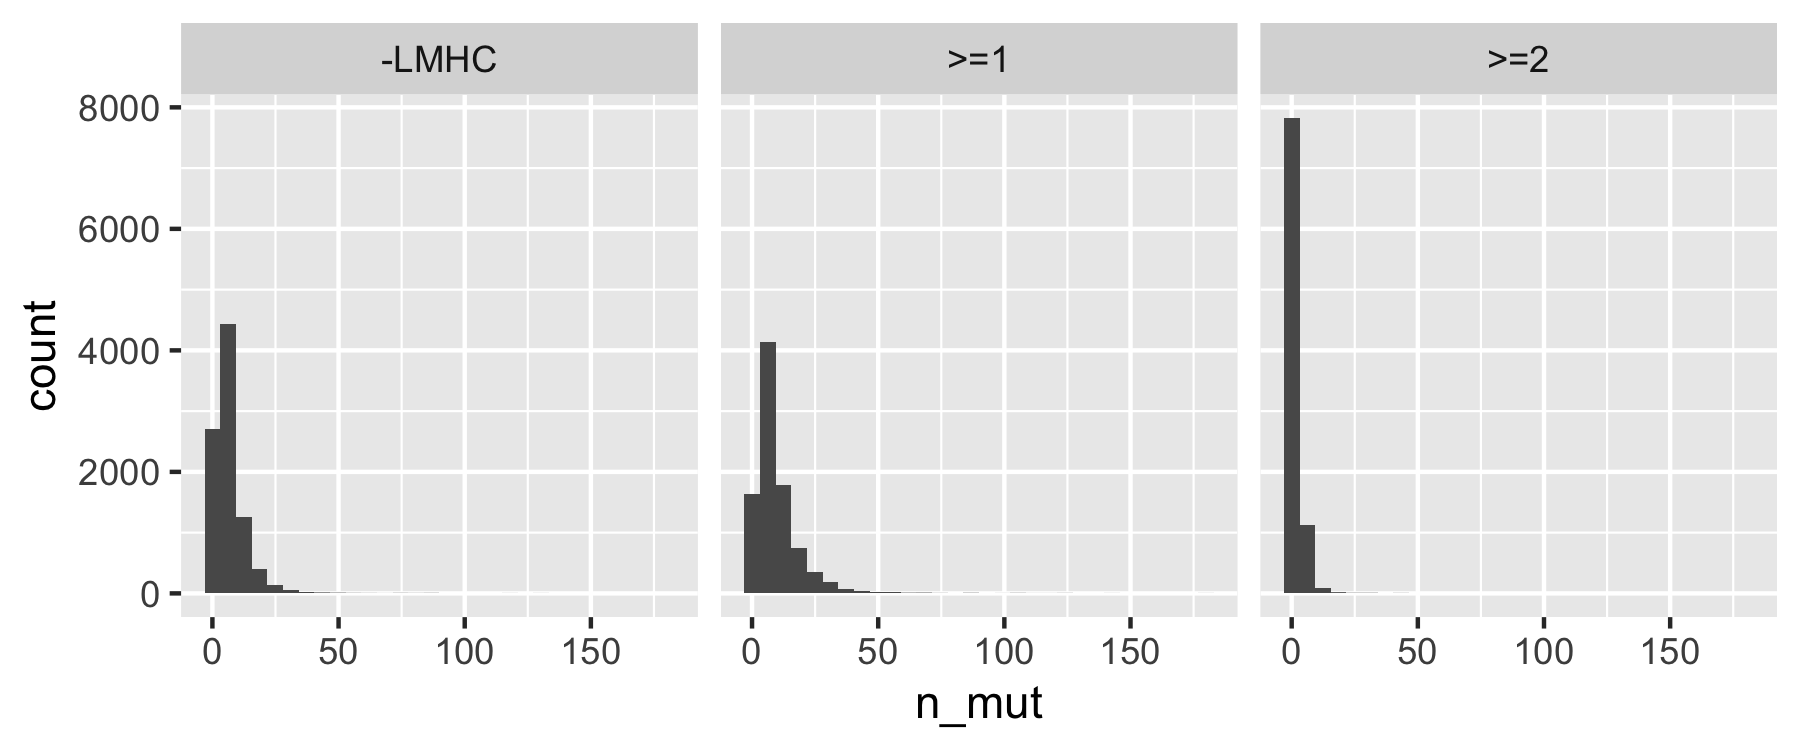

In [85]:
options(repr.plot.width = 6, repr.plot.height = 2.5, repr.plot.res = 300)

mats = list('>=1' = Cts.Mtx.bin1, '>=2' = Cts.Mtx.bin2, '-LMHC' = Cts.Mtx.bin3)

lapply(
    names(mats),
    function(x) {
        rowSums(mats[[x]]) %>% data.frame() %>%
        tibble::rownames_to_column('cell') %>% 
        setNames(c('cell', 'n_mut')) %>%
        mutate(mat = x)
    }
) %>%
bind_rows() %>%
ggplot(
    aes(x = n_mut)
) +
geom_histogram() +
facet_wrap(~mat)

In [86]:
rowSums(cell_cell_connectivity_a) %>% summary
rowSums(cell_cell_connectivity_b) %>% summary
rowSums(cell_cell_connectivity_c) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00    9.00   65.65   73.00 1827.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.6748  0.0000 52.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.000   4.496   4.000 424.000 

In [68]:
# function to make the weights for their jaccard thingy
make_weight_df <- function(Cts.bin){
    # Pull out weights fromt the data object; update with N/As with 1 as described in manuscript
    weightdf<-data.frame(Variants=colnames(Cts.bin)) %>% merge(.,V.weight,by="Variants",all.x = T,sort = F) 
    weight <- weightdf %>% pull(weight)
    weight[is.na(weight)] <- 1
    weight
}

# do the weights
weight1 <- make_weight_df(Cts.Mtx.bin1)
weight2 <- make_weight_df(Cts.Mtx.bin2)
weight3 <- make_weight_df(Cts.Mtx.bin3)

# Compute weighted jaccard distance metric in the paper
w_j1 <- quick_w_jaccard_cl(Cts.Mtx.bin1,weight1) %>% data.matrix()
w_j2 <- quick_w_jaccard_cl(Cts.Mtx.bin2,weight2) %>% data.matrix()
w_j3 <- quick_w_jaccard_cl(Cts.Mtx.bin3,weight3) %>% data.matrix()

In [152]:
# only LMHC
Cts.Mtx.bin4 = Cts.Mtx.bin1
Cts.Mtx.bin4 = Cts.Mtx.bin4 %>% .[,colnames(.) %in% vars_lmhc]
weight4 <- make_weight_df(Cts.Mtx.bin4)
w_j4 <- quick_w_jaccard_cl(Cts.Mtx.bin4,weight4) %>% data.matrix()

In [153]:
phylo4 <- nj(w_j4)
message('tree4')

tree4



In [89]:
phylo1 <- nj(w_j1)
message('tree1')

tree1



In [130]:
phylo2 <- nj(w_j2)
message('tree2')

tree2



In [87]:
phylo3 <- nj(w_j3)
message('tree3')

tree3



Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


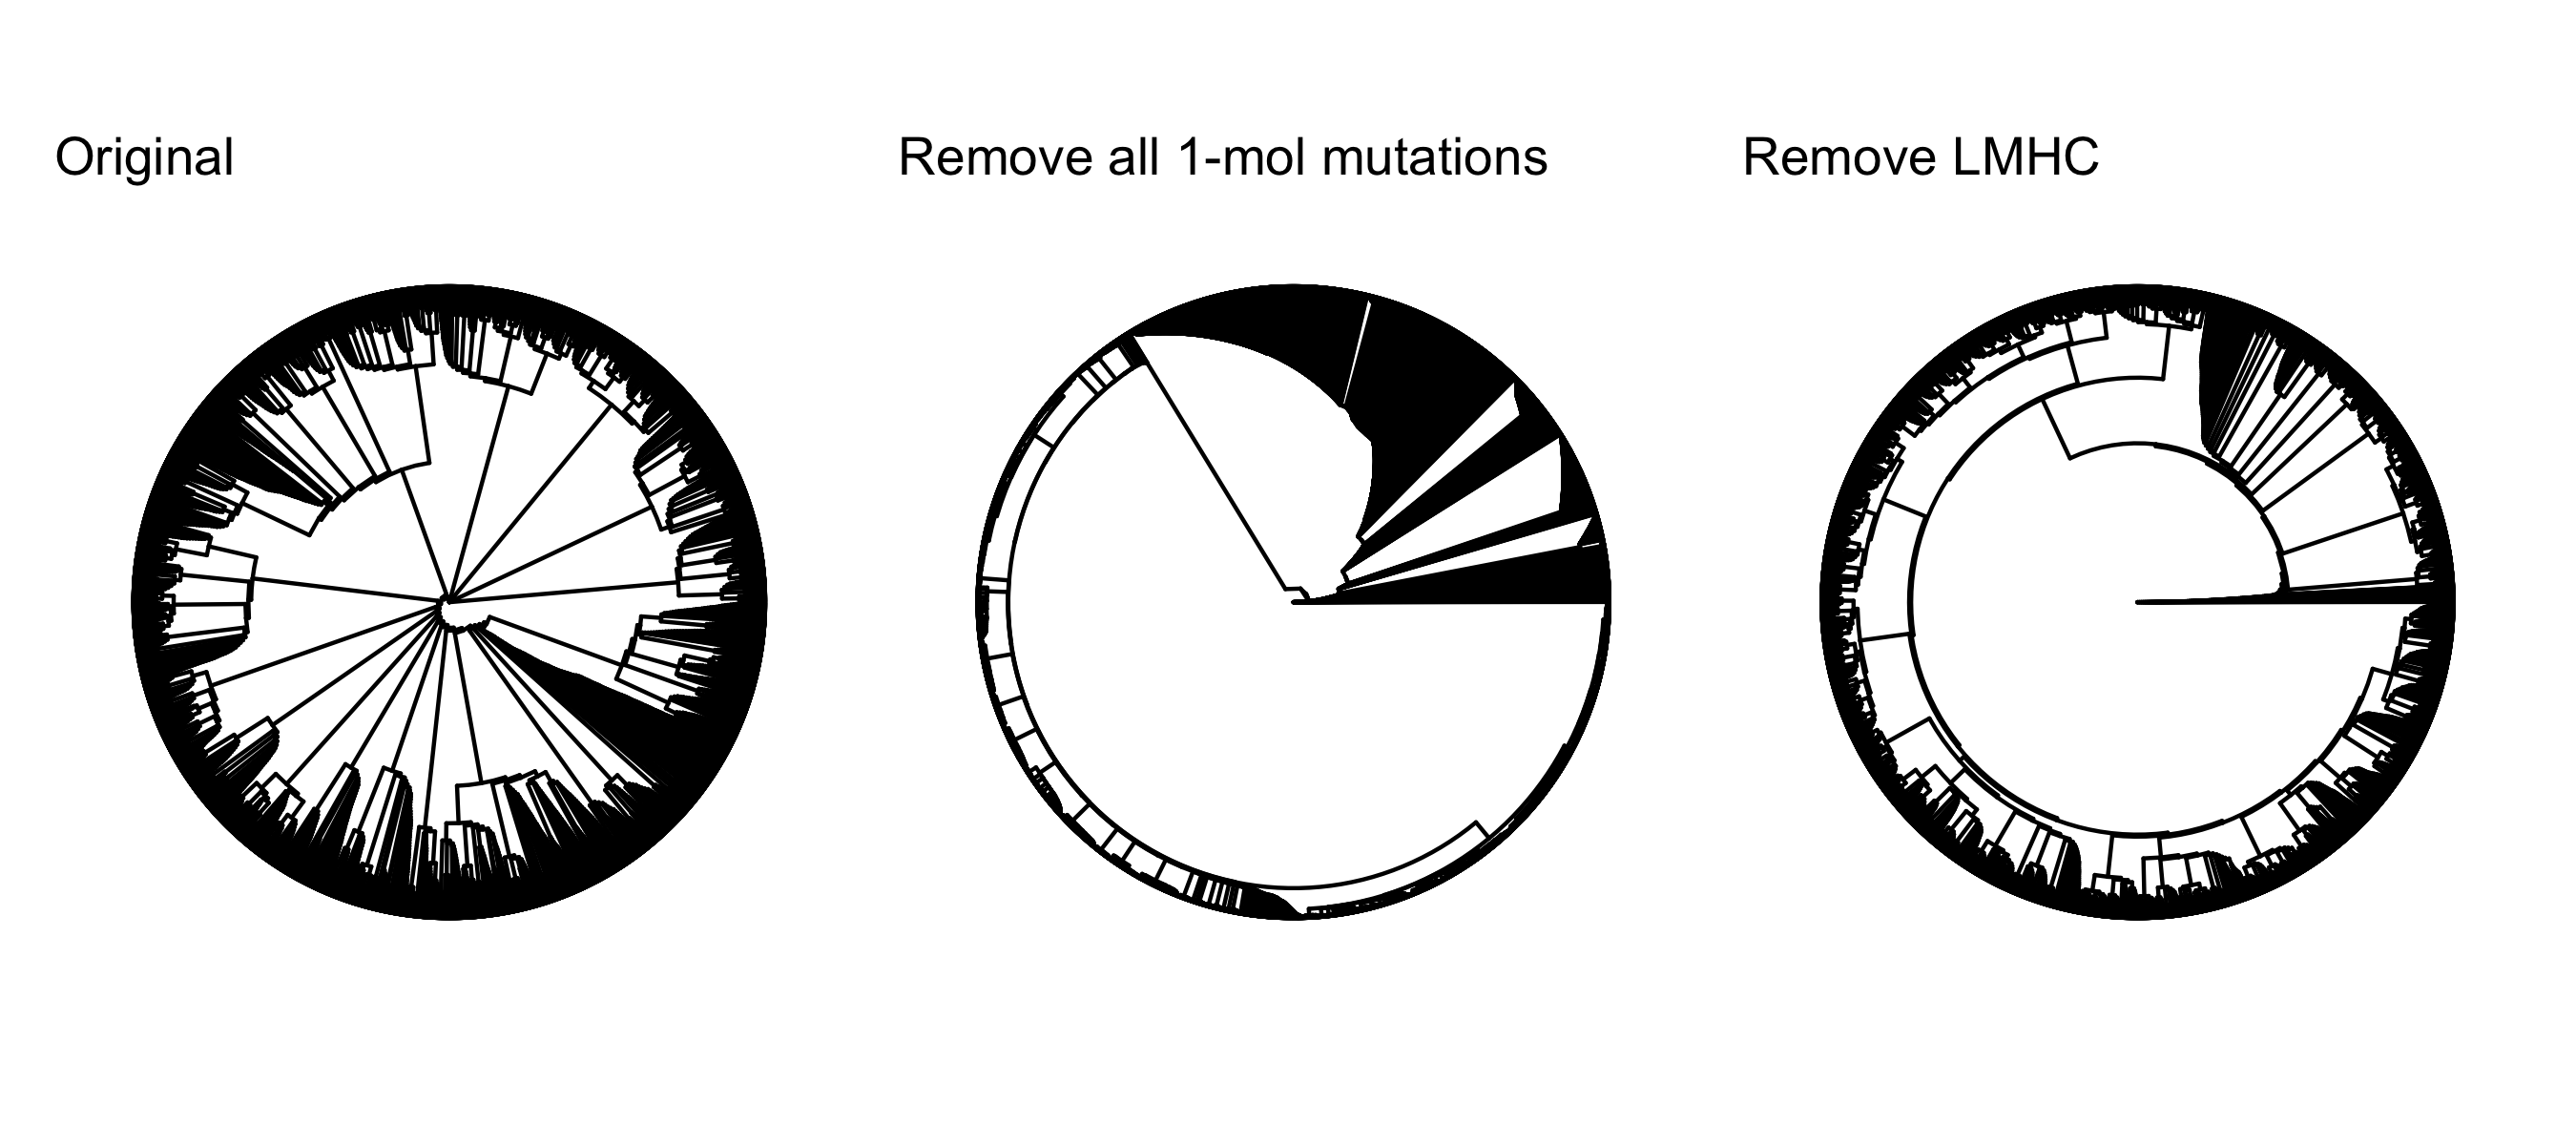

In [162]:
options(repr.plot.width = 9, repr.plot.height = 4, repr.plot.res = 300)

p1 = ggtree(phylo1,layout="fan", branch.length = 'none') + ggtitle('Original')
p2 = ggtree(phylo2,layout="fan", branch.length = 'none') + ggtitle('Remove all 1-mol mutations')
p3 = ggtree(phylo3,layout="fan", branch.length = 'none') + ggtitle('Remove LMHC')

p1 | p2 | p3

In [92]:
w_t_2 = 150

In [180]:
# fwrite(cell_annot_all, 'cell_annot_all.csv')
cell_annot_all = fread('~/redeem/cell_annot_all.csv')
cell_annot = cell_annot_all %>% split(.$sample)

In [186]:
cell_annot[['Old2_BMMC']] %>% colnames

[1] "orig.ident"       "nCount_RNA"       "nFeature_RNA"     "nCount_ATAC"     
 [5] "nFeature_ATAC"    "nCount_SCT"       "nFeature_SCT"     "SCT.weight"      
 [9] "ATAC.weight"      "wsnn_res.0.8"     "seurat_clusters"  "Sig.HSC1"        
[13] "Sig.Prog1"        "Sig.EarlyE1"      "Sig.LateE1"       "Sig.ProMono1"    
[17] "Sig.Mono1"        "Sig.ncMono1"      "Sig.cDC1"         "Sig.pDC1"        
[21] "Sig.ProB1"        "Sig.PreB1"        "Sig.B1"           "Sig.Plasma1"     
[25] "Sig.T1"           "Sig.CTL1"         "Sig.NK1"          "STD.CellType"    
[29] "STD_Cat"          "STD_Cat2"         "sig"              "label"           
[33] "ATACName"         "cell"             "cell_type"        "sample"          
[37] "sample_type"      "donor"            "cohort"           "Amulet"          
[41] "Origin.Seurat"    "MitoCoverage"     "ClonalGroup"      "meanCov"         
[45] "ClonalGroup.Prob"

In [192]:
clone_annot = cell_annot[['Old2_BMMC']] %>% select(Cell = cell, ClonalGroup)

In [93]:
t1 <- ggtree(phylo1,layout="fan", branch.length='none')
ncell <- length(get_taxa_name(t1))

clmdf <- data.frame(
    Cell = get_taxa_name(t1),
    idx = 1:(ncell),
    val = 1:(ncell)/(ncell)
)
  
# Make first tree
t1f <- t1 + geom_fruit( 
    data=clmdf, 
    geom=geom_tile, 
    mapping=aes(y=Cell,x=2,fill=val), 
    pwidth=0.001, 
    width=10, 
    offset=0.05
) + scale_fill_gradientn(colors = jdb_palette("brewer_spectra")) + theme(legend.position = "none")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


In [198]:
clmdf = clmdf %>% left_join(clone_annot, by = 'Cell')

In [205]:
t1f <- t1 + geom_fruit( 
    data=clmdf, 
    geom=geom_tile, 
    mapping=aes(y=Cell,x=2,fill=as.factor(ClonalGroup)), 
    pwidth=0.001, 
    width=10, 
    offset=0.05
) + theme(legend.position = "none")

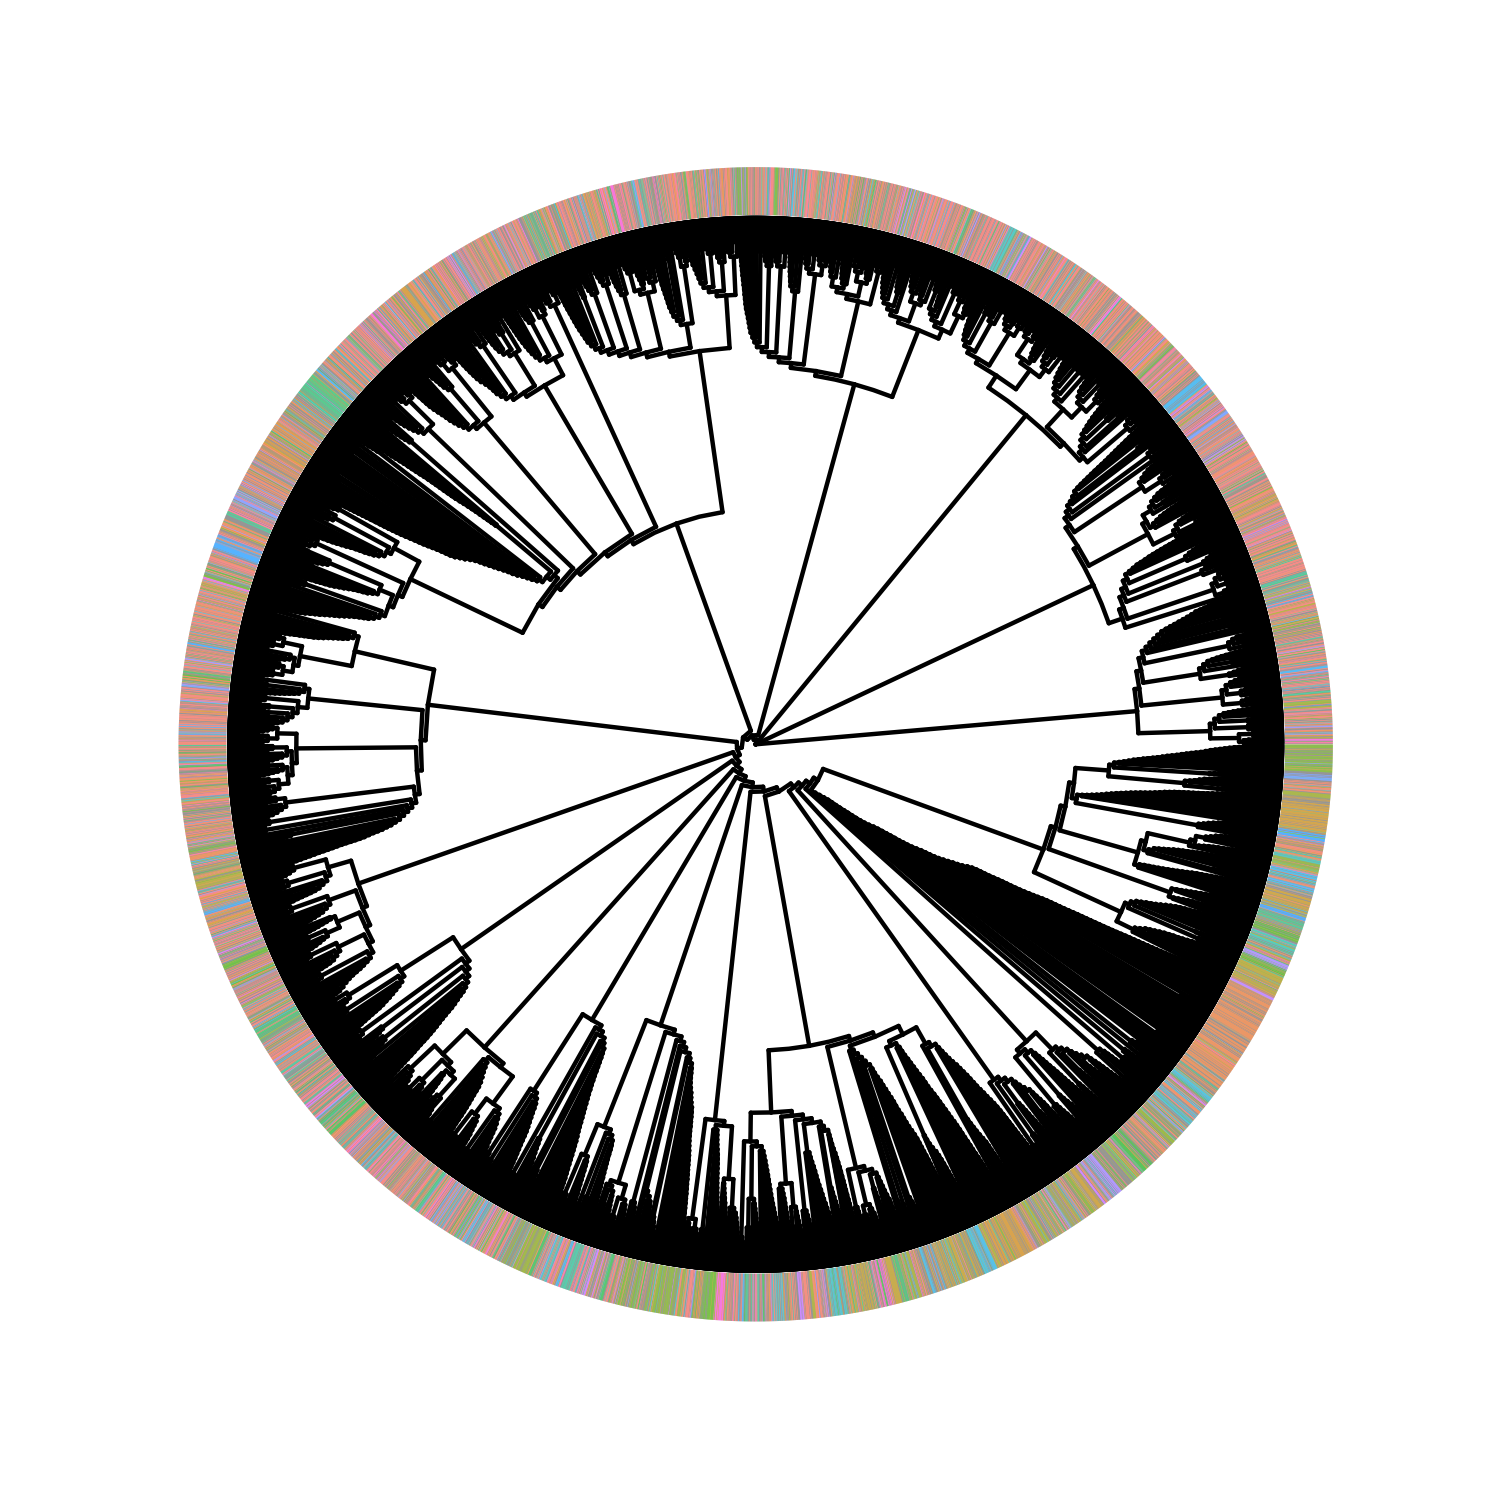

In [206]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 300)

t1f

In [211]:
# Make new tree after filtering
t2 <- ggtree(phylo3,layout="fan", branch.length='none')

t2f = t2 + geom_fruit( 
    data=clmdf, 
    geom=geom_tile, 
    mapping=aes(y=Cell,x=2,fill=as.factor(ClonalGroup)), 
    pwidth=0.001, 
    width=12, 
    offset=0.05
    ) + theme(legend.position = "none")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


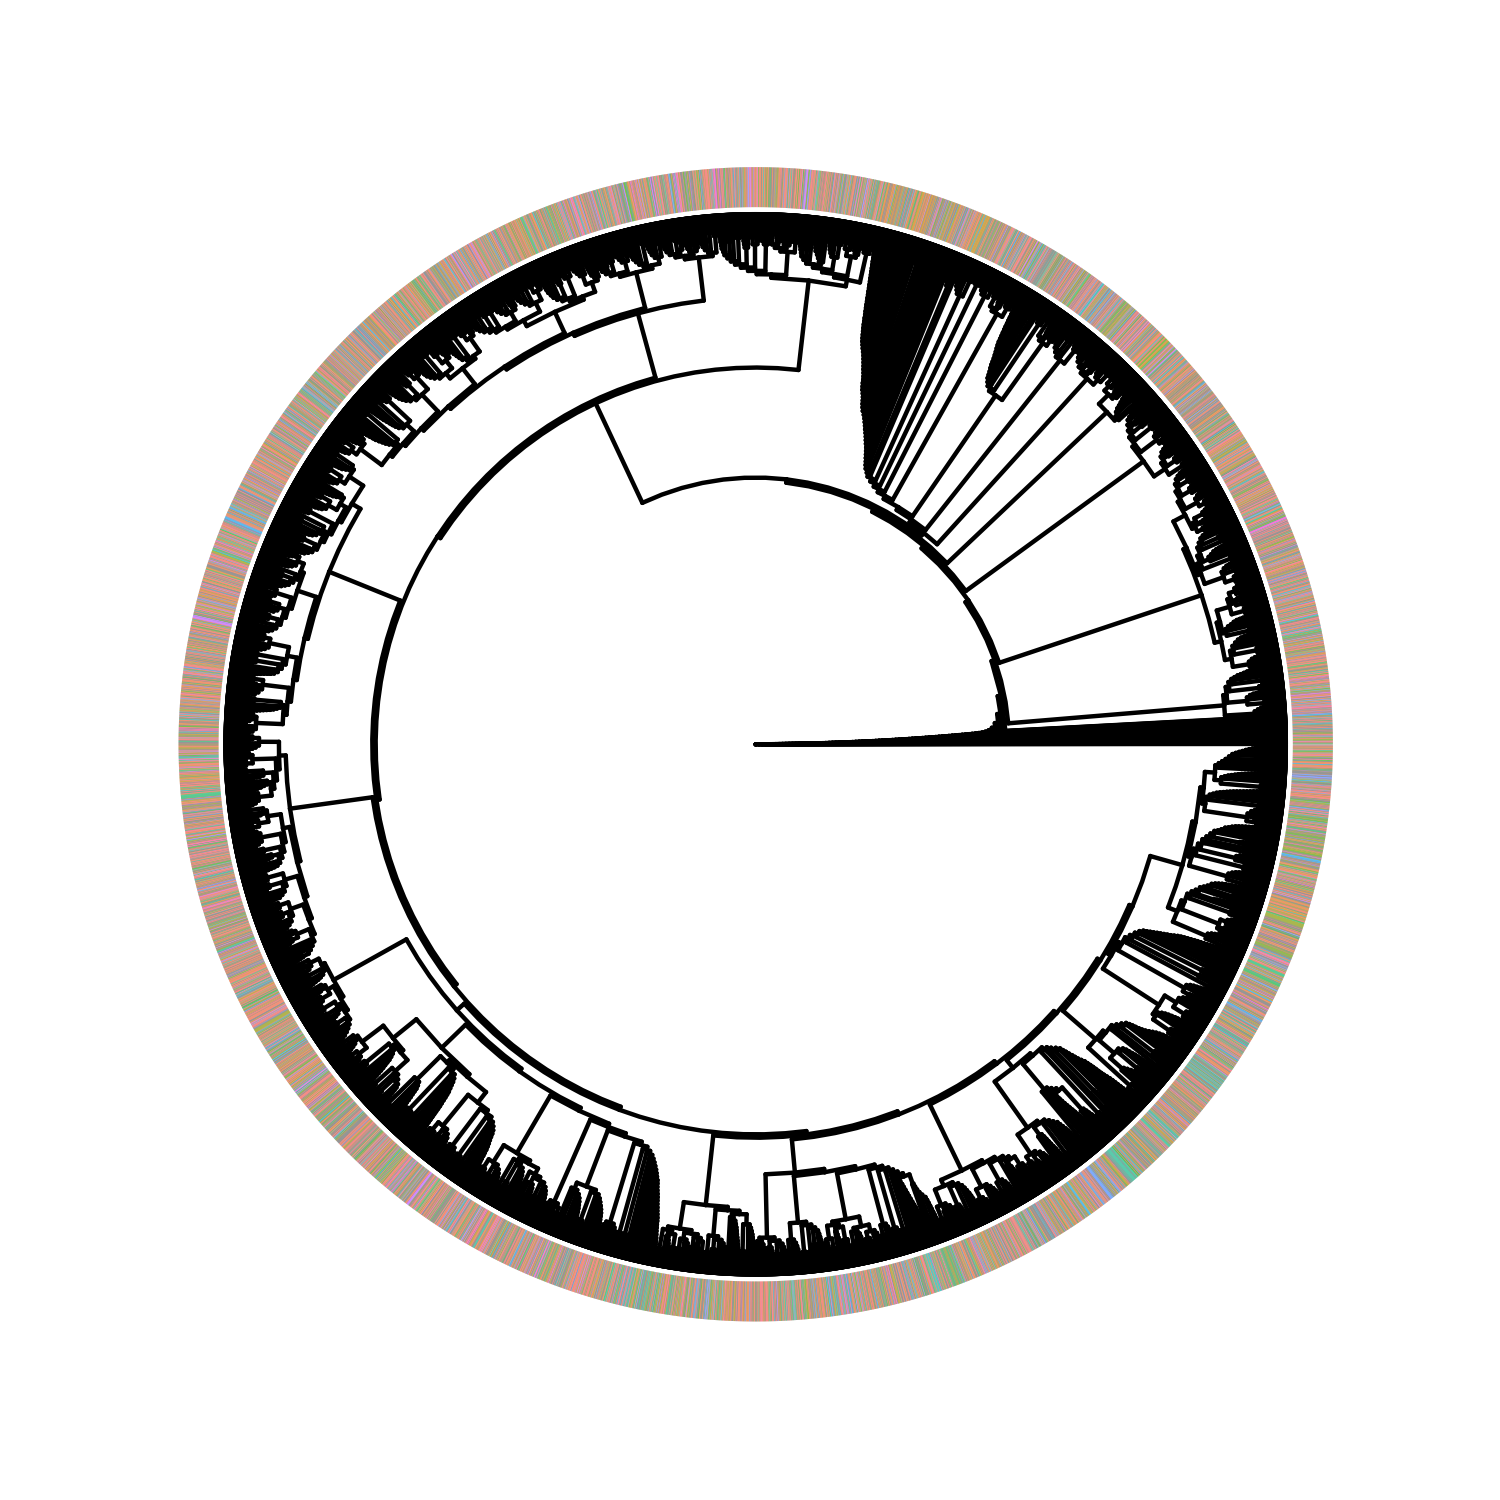

In [212]:
t2f

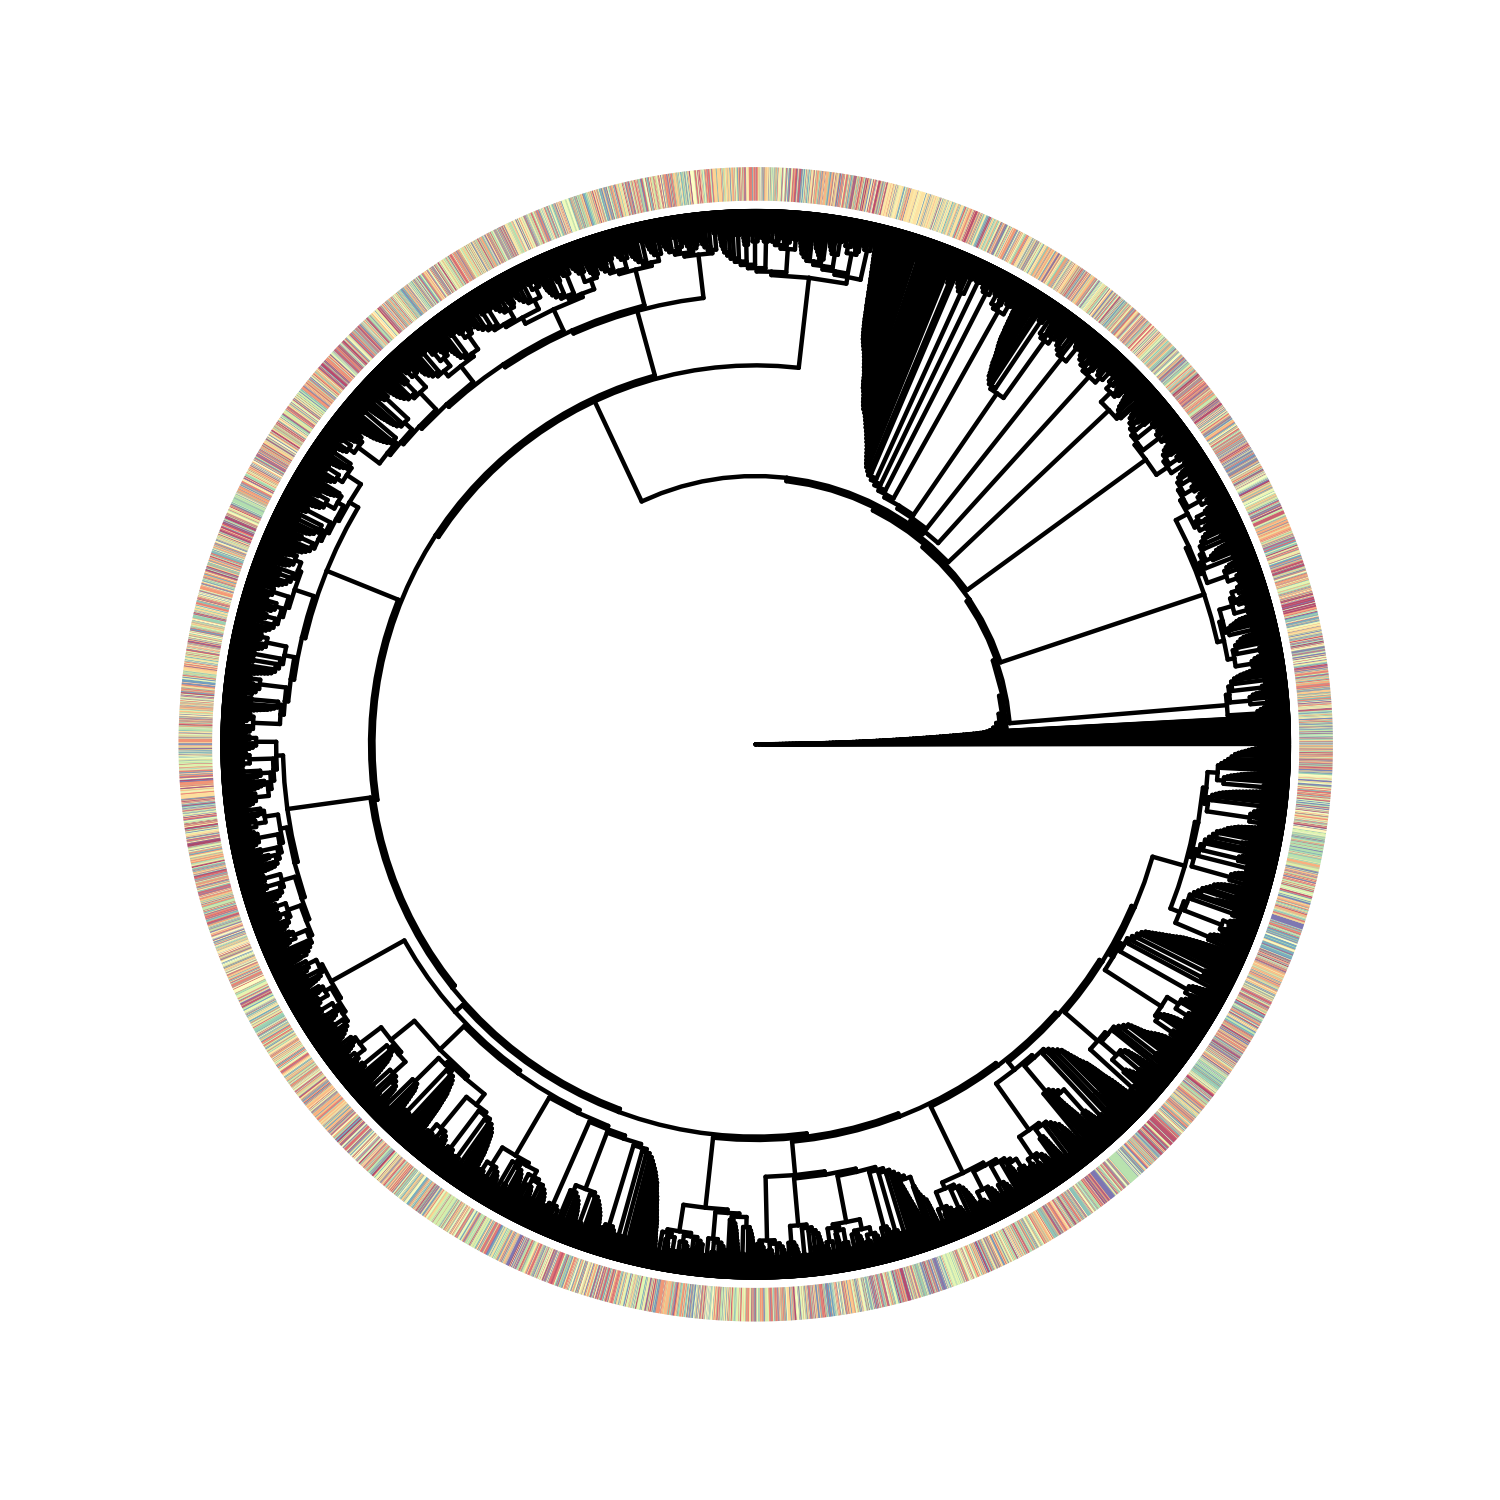

In [101]:
# Make new tree after filtering
t2 <- ggtree(phylo3,layout="fan", branch.length='none')

t2f = t2 + geom_fruit( 
    data=clmdf, 
    geom=geom_tile, 
    mapping=aes(y=Cell,x=2,fill=val), 
    pwidth=0.001, 
    width=10, 
    offset=0.05
    ) + scale_fill_gradientn(colors = jdb_palette("brewer_spectra")) + theme(legend.position = "none")

In [122]:
process_tree_MRCA <- function(t1, t2, nrep = 10, npair = 1000){
    n_nodes <- t1$Nnode
    
    mclapply(1:nrep, mc.cores = 10, function(j){
      lapply(1:npair, function(i){
        set.seed(i+j*50000)
        random3 <- sort(sample(1:n_nodes, size = 3))
        eg <- expand.grid(random3, random3) %>%
          filter(Var1 < Var2)
        d1 <- get_pairwise_distances(t1, A = eg[,1], B= eg[,2])
        d2 <- get_pairwise_distances(t2, A = eg[,1], B= eg[,2])
        data.frame(idx = i,
                   perm = j,
                   match = which.min(d1) == which.min(d2))
      }) %>% rbindlist() %>% data.frame() -> odf
      odf
    }) %>% rbindlist() %>% data.frame() ->  full_df
    full_df
  }

In [132]:
res_1v3 = process_tree_MRCA(phylo1, phylo3, nrep = 10, npair = 1000)
res_1v2 = process_tree_MRCA(phylo1, phylo2, nrep = 10, npair = 1000)

Warning message in mclapply(1:nrep, mc.cores = 10, function(j) {:
“scheduled core 6 did not deliver a result, all values of the job will be affected”


In [160]:
res_1v4 = process_tree_MRCA(phylo1, phylo4, nrep = 10, npair = 1000)

`summarise()` has grouped output by 'perm'. You can override using the `.groups` argument.


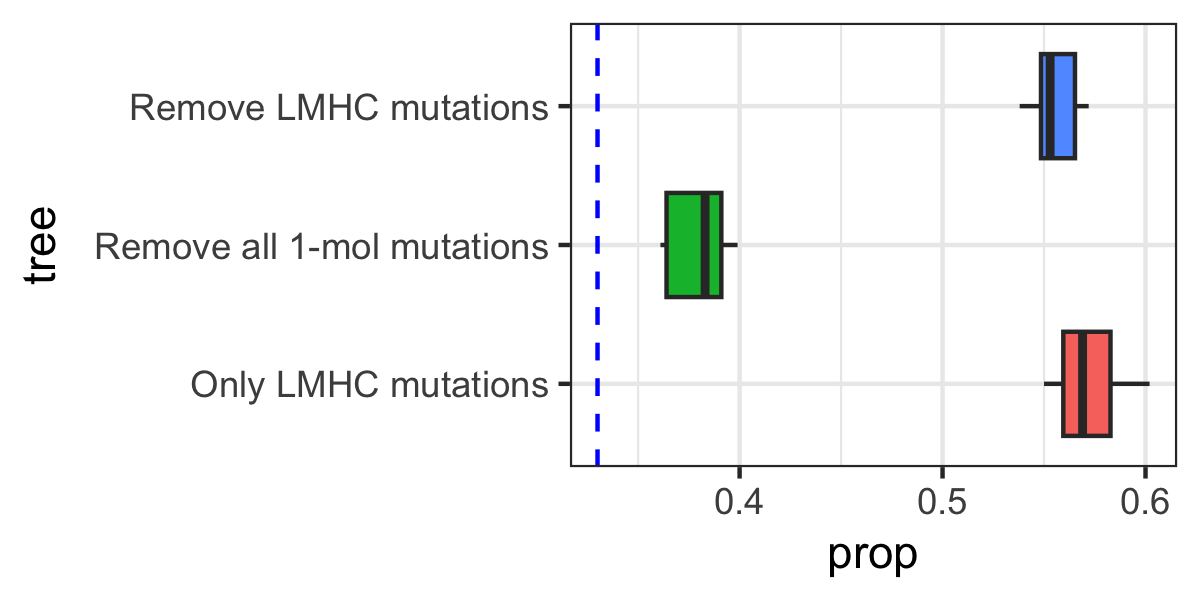

In [175]:
options(repr.plot.width = 4, repr.plot.height = 2, repr.plot.res = 300)

bind_rows(
    res_1v2 %>% mutate(tree = 'Remove all 1-mol mutations'),
    res_1v3 %>% mutate(tree = 'Remove LMHC mutations'),
    res_1v4 %>% mutate(tree = 'Only LMHC mutations')
) %>%
group_by(perm, tree) %>%
summarise(prop = mean(match)) %>%
ggplot(
    aes(x = prop, y = tree, fill = tree)
) +
geom_boxplot(show.legend = F) +
theme_bw() +
geom_vline(xintercept = 0.33, color = 'blue', linetype = 'dashed')

In [161]:
res_1v4 %>% group_by(perm) %>% summarise(prop = mean(match)) %>% pull(prop) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5500  0.5595  0.5690  0.5717  0.5827  0.6020 

In [133]:
res_1v3 %>% group_by(perm) %>% summarise(prop = mean(match)) %>% pull(prop) %>% summary
res_1v2 %>% group_by(perm) %>% summarise(prop = mean(match)) %>% pull(prop) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5380  0.5485  0.5530  0.5559  0.5653  0.5720 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3610  0.3640  0.3830  0.3793  0.3910  0.3990 

In [129]:
res %>% group_by(perm) %>% summarise(prop = mean(match)) %>% pull

perm prop 
1   1   0.554
2   2   0.566
3   3   0.548
4   4   0.552
5   5   0.563
6   6   0.548
7   7   0.550
8   8   0.568
9   9   0.572
10 10   0.538

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


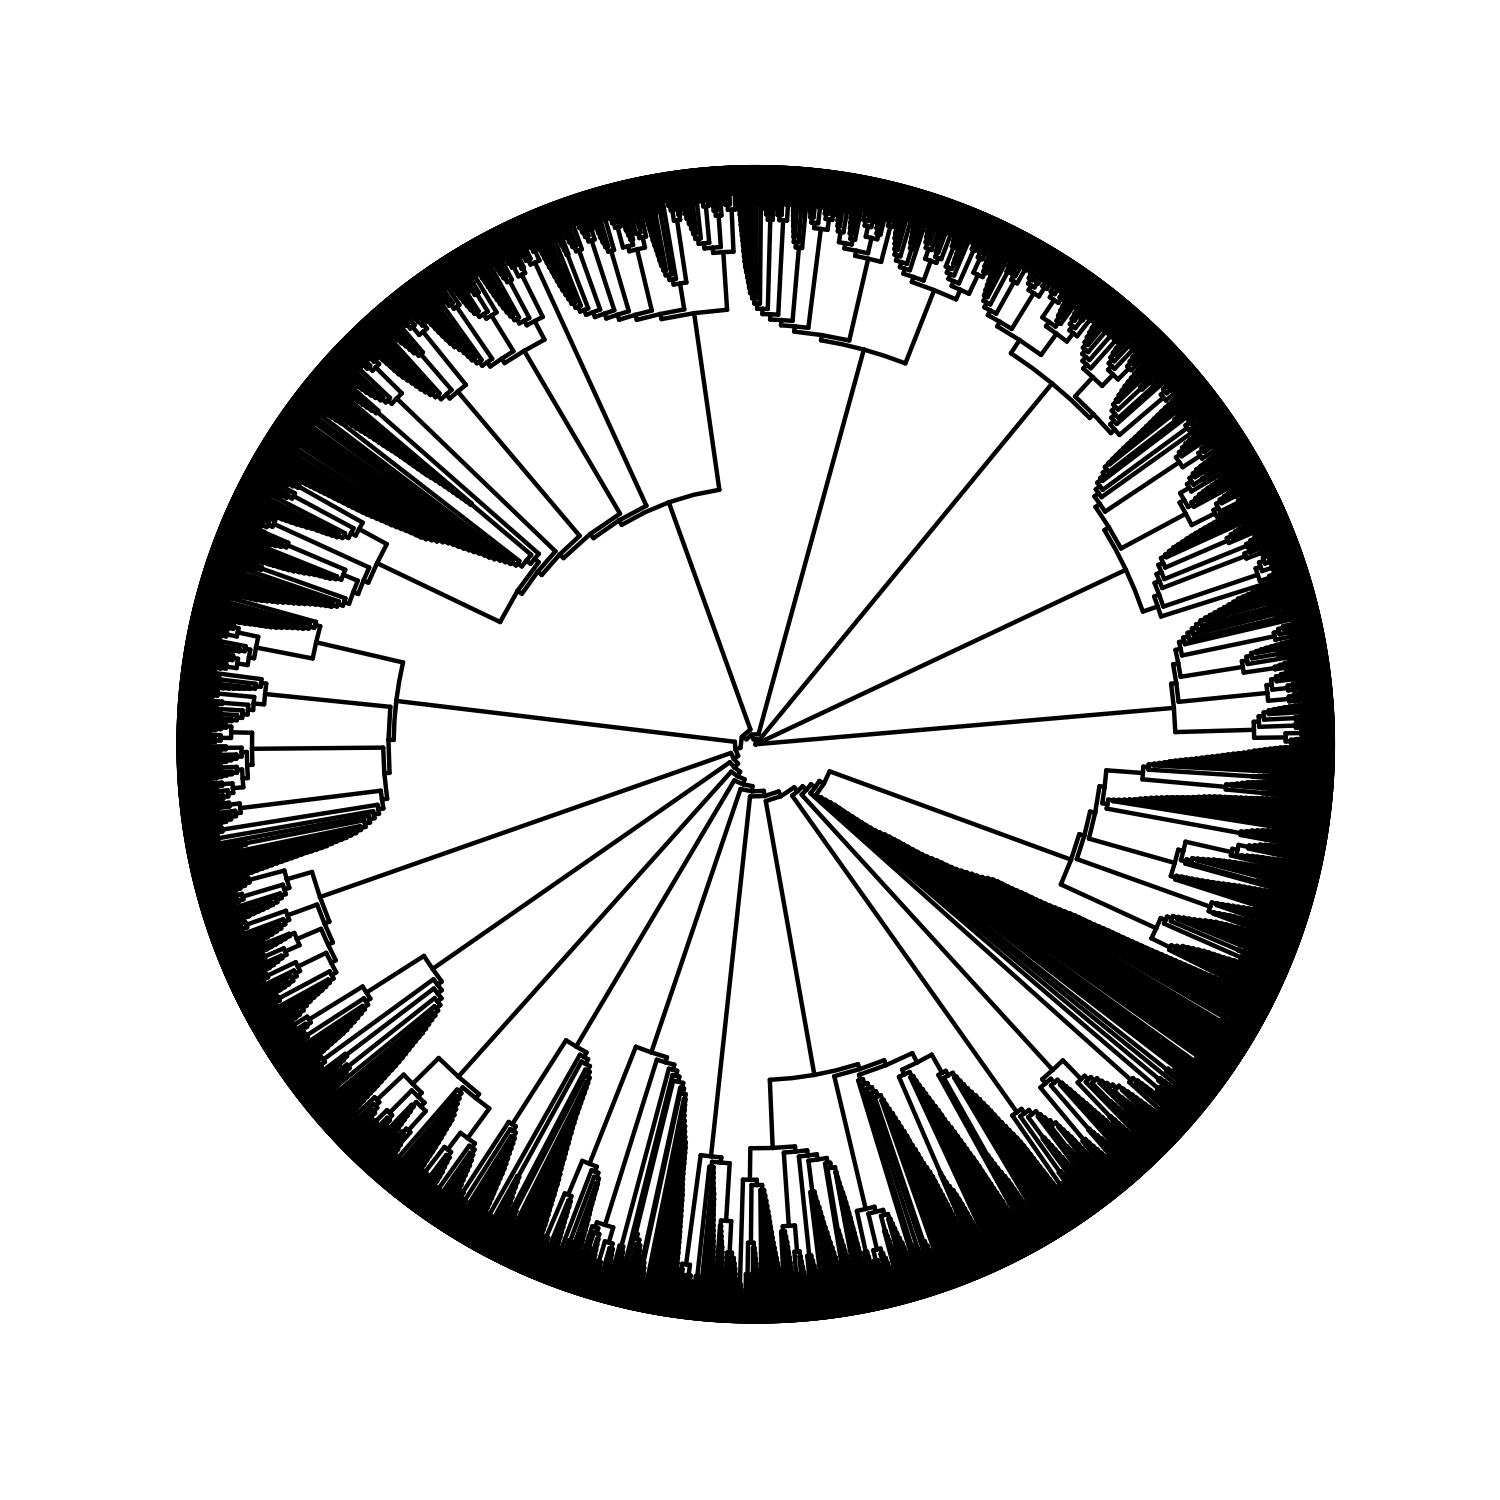

In [90]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 300)

ggtree(phylo1,layout="fan", branch.length = 'none')

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


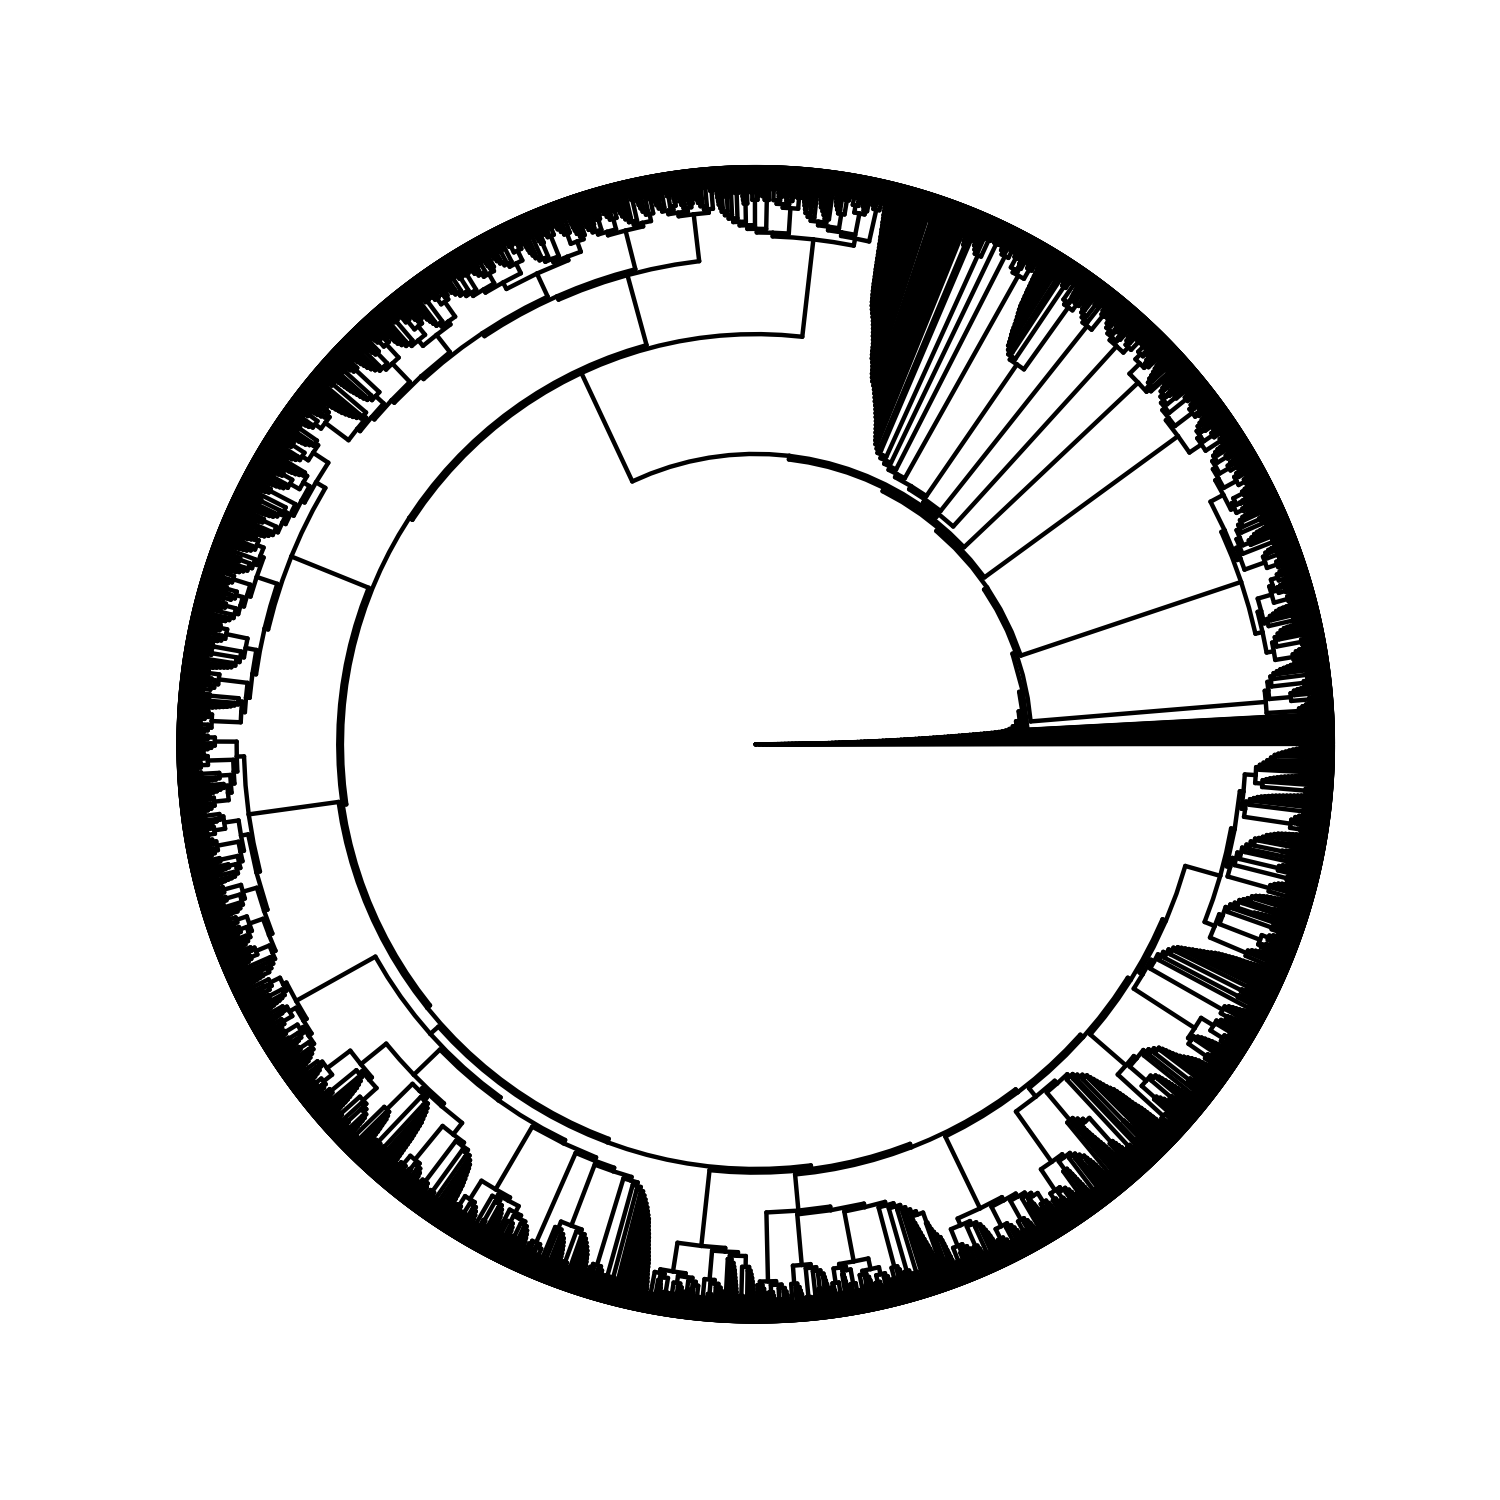

In [88]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 300)

ggtree(phylo3,layout="fan", branch.length = 'none')

In [59]:
1367352/3462648
217838/3462648

[1] 0.3948862

[1] 0.06291081

In [55]:
sum(Cts.Mtx.bin1)
sum(Cts.Mtx.bin2)
sum(Cts.Mtx.bin3)

[1] 88290

[1] 16661

[1] 62508

In [46]:
rowSums(Cts.Mtx.bin1) %>% summary
rowSums(Cts.Mtx.bin3) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   4.000   7.000   9.757  12.000 180.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   3.000   5.000   6.908   9.000 133.000 

In [43]:
Cts.Mtx.bin1 %>% dim
Cts.Mtx.bin3 %>% dim

[1] 9049 6269

[1] 9049 5824

In [40]:
table(colnames(Cts.Mtx.bin1) %in% vars_lmhc)


FALSE  TRUE 
 5824   445 

In [49]:
sum(cell_cell_connectivity1)
sum(cell_cell_connectivity2)
sum(cell_cell_connectivity4)

[1] 594060

[1] 6106

[1] 40686

In [51]:
6106/594060
40686/594060

[1] 0.01027842

[1] 0.06848803

In [ ]:

lapply(c("Young1.T1.BMMC", "Youn2.BMMC", "Old1.BMMC", "Old2.BMMC"), function(x){
  analyze_connectivity_impact(x)
}) %>% rbindlist() %>% data.frame() -> pct_df12

(pct_df12 %>%
  mutate(original = original_connections/n_cells, 
         only1 = connections_wOnly1/n_cells))[,c("id", "original", "only1")]


(pct_df12 %>%
    mutate(original = original_connections/n_cells/n_cells*100, 
           only1 = connections_wOnly1/n_cells/n_cells*100))[,c("id", "original", "only1")]


pX <- pct_df12 %>%
  ggplot(aes(x = id, y = pct_connections_lost)) + 
  geom_bar(stat = "identity", color = "black", fill = "lightgrey", width = 0.6) + 
  pretty_plot(fontsize = 7) + L_border() + 
  scale_y_continuous(expand = c(0,0), limits = c(0, 100)) + 
  labs(x = "", y = "% connectivity lost")
cowplot::ggsave2(pX, file = "../final_plots/connectivity_lost.pdf", width = 1.4, height = 1)


pct_go <-  pct_df12 %>% mutate(Weng = original_connections/n_cells, 
                               zPostFilter = connections_after_filter1/n_cells)

pY <- pct_go[,c("id","Weng", "zPostFilter")] %>%
  reshape2::melt(id.vars = "id") %>% 
  ggplot(aes(x = id, y = value, fill = variable)) + 
  geom_bar(stat = "identity", color = "black", width = 0.6, position = position_dodge2()) + 
  pretty_plot(fontsize = 7) + L_border() + 
  scale_y_continuous(expand = c(0,0), limits = c(0, 70)) + 
  labs(x = "", y = "mean connectivity") + 
  scale_fill_manual(values = c("grey1", "grey")) +
  theme(legend.position = "none")
cowplot::ggsave2(pY, file = "../final_plots/n_connections_more1.pdf", width = 2, height = 1)

#############

boosted_go <-  pct_df12 %>% mutate(Weng = original_connections/n_cells, 
                               zPostMod = connections_wOnly1/n_cells)

pZ <- boosted_go[,c("id","Weng", "zPostMod")] %>%
  reshape2::melt(id.vars = "id") %>% 
  ggplot(aes(x = id, y = value, fill = variable)) + 
  geom_bar(stat = "identity", color = "black", width = 0.6, position = position_dodge2()) + 
  pretty_plot(fontsize = 7) + L_border() + 
  scale_y_continuous(expand = c(0,0), limits = c(0, 400)) + 
  labs(x = "", y = "mean connectivity") + 
  scale_fill_manual(values = c("grey1", "grey")) +
  theme(legend.position = "none")
pZ
cowplot::ggsave2(pZ, file = "../final_plots/n_connections_only1.pdf", width = 2, height = 1)
